# Lecture : Shallow Graph Feature Learning

## Lab 02 : Introduction to Graphs with DGL, NetworkX, PyTorch - Exercise

### Xavier Bresson, Guoji Fu  

<br>
Notebook goals :<br>  
• Build a graph with Deep Graph Library (DGL) [1] <br>  
• Compute a message-passing function with DGL <br>  
• Create a batch of DGL graphs <br>  
• Convert DGL graph to NetworkX graph for visualization w/ balanced springs system [2] <br>
• Convert DGL graph to PyTorch graph for visualization w/ Laplacian eigenvectors [3] <br>
• Conversions between DGL, NetworkX, (dense and sparse) PyTorch graphs <br><br>  

[1] Wang et-al, Deep graph library: A graph-centric, highly-performant package for graph neural networks, 2019  
https://www.dgl.ai  
[2] Kamada, Kawai, An algorithm for drawing general undirected graphs, 1989  
https://shorturl.at/fpDV2    
[3] Belkin, Niyogi,Laplacian eigenmaps for dimensionality reduction and data representation, 2003  
http://graphics.stanford.edu/courses/cs233-20-spring/ReferencedPapers/Laplacian.pdf


In [2]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/07_Shallow_Learning'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==1.0.0 # Install DGL


In [3]:
# Libraries
import dgl
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_LapEig


## Exercise 1 : Build a graph with Deep Graph Library (DGL)

### Question 1.1 : Create a cycle graph of 7 nodes with DGL and convert it to a bidirectional graph

Instructions:
- Use `dgl.graph(data, num_nodes=None)` to create the graph in DGL.  
- The graph is initialized with two lists: one containing the source node indices and the other containing the corresponding destination indices. These lists define all the edges in the graph.
- To convert the directed graph into an undirected (bidirectional) graph, you can use `dgl.to_bidirected(graph)`.


In [4]:
list_src = []
list_dst = []
num_nodes = 7
for i in range(num_nodes):
    list_src.append(i)
    list_dst.append((i+1)%num_nodes)
print([list_src,list_dst])

###############################################
# YOUR CODE START
###############################################

# create DGL graph
orig_graph_dgl = dgl.graph((list_src, list_dst))

# convert the graph to a symmetrize/undirected graph
graph_dgl = dgl.to_bidirected(orig_graph_dgl)

###############################################
# YOUR CODE END
###############################################

print(graph_dgl)


[[0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 0]]
Graph(num_nodes=7, num_edges=14,
      ndata_schemes={}
      edata_schemes={})


### Question 1.2 : Add node and edge features to the previously defined DGL graph

Add node in-degrees as the node features and random features as the edge features to the DGL graph.

Instructions:
- Let `g = dgl.graph(data)` be the DGL graph.
- To add node features (e.g. 'in-degree'), use `g.ndata['feat_name']`, where `'feat_name'` is the name of the feature you wish to assign.
- To add edge features, use `g.edata['feat_name']`, where `'feat_name'` corresponds to the feature name for the edges.
- To compute the in-degrees for the nodes, use `g.in_degrees().view(-1, 1).float()`. This will return a tensor of the in-degrees for each node.
- To generate random edge features, use `torch.rand(g.num_edges(), 100)`, which creates random features with 100 dimensions for each edge.
- You can obtain the number of edges using `g.num_edges()`.


In [5]:
###############################################
# YOUR CODE START
###############################################

# Add node in-degrees as node features to the DGL graph
graph_dgl.ndata['feat'] = graph_dgl.in_degrees().view(-1, 1).float() # node in-degree

# Add random features as edge features to the DGL graph
graph_dgl.edata['feat'] =  torch.rand(graph_dgl.num_edges(), 100)# random features

###############################################
# YOUR CODE END
###############################################

print(graph_dgl)


Graph(num_nodes=7, num_edges=14,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(100,), dtype=torch.float32)})


## Exercise 2 : Compute a message-passing function with DGL

### Question 2.1 : Implement Step 1 of a message-passing function with DGL

Define the **Message** function to pass node and edge features along **edges**, i.e. from src/j to dst/i.

Hints:
- To access the features of destination nodes `dst`, use `edges.dst['feat_name']`, where `'feat_name'` is the name of the feature for the destination nodes.
- To access the features of source nodes `src`, use `edges.src['feat_name']`, where `'feat_name'` is the name of the feature for the source nodes.
- To access the features of edges, use `edges.data['feat_name']`, where `'feat_name'` is the name of the feature for the edges themselves.
  

In [6]:
# Step 1 of message-passing with DGL
#   Node feature and edge features are passed along edges (src/j => dst/i)
def message_func(edges):
    ###############################################
    # YOUR CODE START
    ###############################################
    # hi with i/dst, size=(E,d=1), E=num_edges
    hi = edges.dst['feat']

    # hj with j/src, size=(E,d=1)
    hj = edges.src['feat']

    # eji from src/j to dst/i, size=(E,d=100)
    eji = edges.data['feat']

    # update edge feature value
    edges.data['feat'] = 2 * edges.data['feat']

    ###############################################
    # YOUR CODE END
    ###############################################
    print('hi',hi.size())
    print('hj',hj.size())
    print('eji',eji.size())

    return {'hj' : hj, 'eji' : eji} # send message={hj, eji} to node dst/i

### Question 2.2 : Implement Step 2 of amessage-passing with DGL

Define the **Reduce** function to compute the sum of all messages `{hj, eji}` sent to the **nodes** `dst/i` in Step 1.

Hints:
- To access the node features for each destination node `dst/i`, use `nodes.data['feat_name']`, where `'feat_name'` is the name of the feature.
- To access the received messages for the feature `hj`, use `nodes.mailbox['hj']`, which provides the incoming messages for each node.
- To access the received edge features `eji`, use `nodes.mailbox['eji']`.
- Update the node feature for each node `i` according to the equation:
$$h_i \leftarrow h_i + \sum_{j \in N(i)}e_{ji} \cdot h_j,$$
  where $N(i)$ is the set of neighbors of node i.


In [7]:
# Step 2 of message-passing with DGL:
# Reduce function collects all messages={hj, eji} sent to node dst/i with Step 1
def reduce_func(nodes):
    ###############################################
    # YOUR CODE START
    ###############################################

    # get node features for each node dst/i, size=(N,d=1), N=num_nodes
    hi = nodes.data['feat']

    # get all node features sent to node dst/i, size=(N,|Nj|,d=1), |Nj|=num_neighbors
    hj = nodes.mailbox['hj']

    # get all edge features sent to node dst/i, size=(N,|Nj|,d=100), |Nj|=num_neighbors
    eji = nodes.mailbox['eji']

    # Update node feature by: h = hi + sum_j eta_ji * hj, size=(N,d=100)
    h = hi + torch.sum( eji * hj, dim=1 )

    ###############################################
    # YOUR CODE END
    ###############################################

    print('hi',hi.size())
    print('hj',hj.size())
    print('eji',eji.size())
    print('h',h.size())
    return {'h' : h} # return update node feature hi

graph_dgl.update_all(message_func,reduce_func) # update the node and edge features with DGL


hi torch.Size([14, 1])
hj torch.Size([14, 1])
eji torch.Size([14, 100])
hi torch.Size([7, 1])
hj torch.Size([7, 2, 1])
eji torch.Size([7, 2, 100])
h torch.Size([7, 100])


## Exercise 3: Create a batch of (two) DGL graphs

Define a **collate** function to prepare a batch of graphs, labels and other graph features (if available).

Instructions:
- Let `graphs` be a set of DGL graphs.
- Use `dgl.batch(graphs)` to combine the individual graphs into a single batch.
  

In [8]:
# generate two DGL graphs
list_src = torch.randperm(8).tolist()
list_dst = torch.randperm(8).tolist()
graph_dgl = dgl.graph((list_src, list_dst))
graph_dgl = dgl.to_bidirected(graph_dgl)
graph_dgl.ndata['feat'] = graph_dgl.in_degrees().view(-1, 1).float() # node in-degree
graph_dgl.edata['feat'] = torch.rand(graph_dgl.num_edges(), 100) # random features
g1 = graph_dgl
label1 = torch.tensor(0).long()
print('g1, label1', g1, label1)
list_src = torch.randperm(16).tolist()
list_dst = torch.randperm(16).tolist()
graph_dgl = dgl.graph((list_src, list_dst))
graph_dgl = dgl.to_bidirected(graph_dgl)
graph_dgl.ndata['feat'] = graph_dgl.in_degrees().view(-1, 1).float() # node in-degree
graph_dgl.edata['feat'] = torch.rand(graph_dgl.num_edges(), 100) # random features
g2 = graph_dgl
label2 = torch.tensor(1).long()
print('g2, label2', g2, label2)
trainset = [ [g1, label1] , [g2, label2] ]
print('trainset', trainset)

# define collate function prepares a batch of graphs, labels and other graph features (if needed)
def collate(samples):
    # Input sample is a list of pairs (graph, label)
    graphs, labels = map(list, zip(*samples))

    ###############################################
    # YOUR CODE START
    ###############################################

    batch_graphs =  dgl.batch(graphs)# batch of graphs
    batch_labels =  torch.tensor(labels)# batch of labels

    ###############################################
    # YOUR CODE END
    ###############################################

    return batch_graphs, batch_labels

# Generate a batch of graphs
batch_size = 2
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
print('batch_graphs', batch_graphs)
print('batch_labels', batch_labels)
batch_x = batch_graphs.ndata['feat']
print('batch_x:',batch_x.size())
batch_e = batch_graphs.edata['feat']
print('batch_e:',batch_e.size())


g1, label1 Graph(num_nodes=8, num_edges=12,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(100,), dtype=torch.float32)}) tensor(0)
g2, label2 Graph(num_nodes=16, num_edges=28,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(100,), dtype=torch.float32)}) tensor(1)
trainset [[Graph(num_nodes=8, num_edges=12,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(100,), dtype=torch.float32)}), tensor(0)], [Graph(num_nodes=16, num_edges=28,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(100,), dtype=torch.float32)}), tensor(1)]]
batch_graphs Graph(num_nodes=24, num_edges=40,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(100,), dtype=torch.float32)})
batch_labels tensor([1, 

## Exercise 4 : Conversions between DGL, NetworkX, (dense and sparse) PyTorch graphs

### Question 4.1 : Convert a DGL graph to a NetworkX graph

Instructions:
- Let `g` be a DGL graph.
- Use `g.to_networkx()` to convert `g` to a NetworkX graph.
  

In [9]:
# build dgl graph
list_src = []
list_dst = []
num_nodes = 7
for i in range(num_nodes):
    list_src.append(i)
    list_dst.append((i+1)%num_nodes)
graph_dgl = dgl.graph((list_src, list_dst))
graph_dgl = dgl.to_bidirected(graph_dgl)

###############################################
# YOUR CODE START
###############################################

# dgl => networkx
graph_nx = graph_dgl.to_networkx()

###############################################
# YOUR CODE END
###############################################


### Question 4.2 : Visualise a graph with NetworkX

Instructions:
- Let `g` be a NetworkX graph,
- Use `networkx.draw(g)` to visualize a graph with networkx.
  

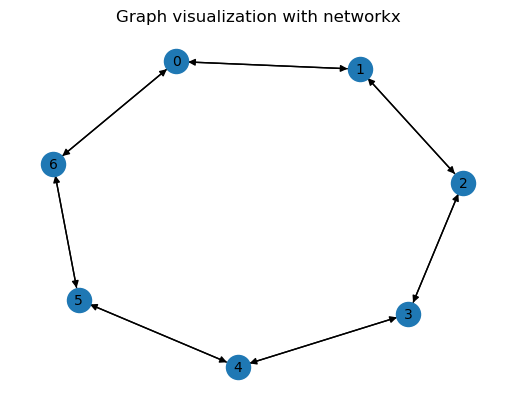

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

###############################################
# YOUR CODE START
###############################################

nx.draw(graph_nx, ax=ax, with_labels=True, font_size=10) # visualise node indexes

###############################################
# YOUR CODE END
###############################################

ax.title.set_text('Graph visualization with networkx')
plt.show()


### Question 4.3 : Visualise a graph with the eigenvectors (i.e. map a graph to a k-dim Euclidean space)

Instructions:
- Let `g` be a DGL graph.
- Use `compute_LapEig()` to get the first two eigenvectors of a DGL graph.
- Visualise the graph with the obtained two eigenvectors.
  

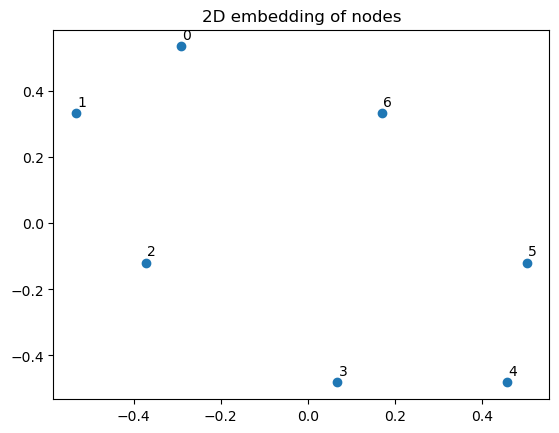

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = compute_LapEig(graph_dgl, 2)
ax.scatter(x[:,0], x[:,1])
idx = list(range(graph_dgl.number_of_nodes()))
for i, txt in enumerate(idx):
    ax.annotate(txt, (x[:,0][i], x[:,1][i]), textcoords="offset points", xytext=(1,5))
ax.title.set_text('2D embedding of nodes')
plt.show()


### Question 4.4 : Convert a DGL graph to a PyTorch tensor

Hints:
- Let `g` be a DGL graph.
- Use `g.adj().to_dense()` to convert `g` to a PyTorch tensor.


In [12]:
###############################################
# YOUR CODE START
###############################################

graph_pytorch = graph_dgl.adj().to_dense()

###############################################
# YOUR CODE END
###############################################

print(graph_pytorch)


tensor([[0., 1., 0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 0., 1., 0.]])


## All type convertors

NetworkX  
https://networkx.org/documentation/stable/reference/convert.html

Sparse PyTorch  
https://pytorch.org/docs/stable/sparse.html

DGL   
https://docs.dgl.ai/api/python/dgl.sparse_v0.html#sparse-matrix-class

In [13]:
# dgl
print('# dgl\n',graph_dgl, type(graph_dgl)); print('\n')

# dgl => networkx
graph_nx = graph_dgl.to_networkx()
print('# dgl => networkx\n',graph_nx, type(graph_nx)); print('\n')

# networkx => dgl
graph_dgl = dgl.from_networkx(graph_nx)
print('# networkx => dgl\n',graph_dgl, type(graph_dgl))
print('Note: Node and edge features must be re-generated!'); print('\n')

# networkx => (coo) sparse pytorch
# Note: edges in sparse pytorch are structured as [ list_src, list_dst ]
src=[]; dst=[]; [(src.append(edge[0]), dst.append(edge[1])) for edge in nx.to_edgelist(graph_nx)] # extract list of edges
graph_sptorch = torch.sparse_coo_tensor([src, dst], [1]*len(src), size=(num_nodes,num_nodes))
print('# networkx => (coo) sparse pytorch\n',graph_sptorch, type(graph_sptorch)); print('\n')

# (coo) sparse pytorch => networkx
# Note: edges in networkx are structure as [ list(src,dst) ]
indices = graph_sptorch.coalesce().indices()
values = graph_sptorch.coalesce().values()
src = indices[0].tolist(); dst = indices[1].tolist(); list_edges = [edge for edge in zip(src,dst)]
graph_nx = nx.Graph(list_edges)
print('# (coo) sparse pytorch => networkx\n', graph_nx, type(graph_nx)); print('\n')

# (coo) sparse pytorch => dense pytorch
graph_pytorch = graph_sptorch.to_dense()
print('# (coo) sparse pytorch => dense pytorch\n', graph_pytorch, type(graph_pytorch)); print('\n')

# dense pytorch => (coo) sparse pytorch
graph_sptorch = graph_pytorch.to_sparse()
print('# dense pytorch => (coo) sparse pytorch\n', graph_sptorch, type(graph_sptorch)); print('\n')

# dgl => (coo) sparse pytorch
graph_sptorch = graph_dgl.adj()
print('# dgl => (coo) sparse pytorch\n', graph_sptorch, type(graph_sptorch)); print('\n')

# dgl => (coo) sparse pytorch => dense pytorch
graph_pytorch = graph_dgl.adj().to_dense()
print('# dgl => dense pytorch\n', graph_pytorch, type(graph_pytorch)); print('\n')



# dgl
 Graph(num_nodes=7, num_edges=14,
      ndata_schemes={}
      edata_schemes={}) <class 'dgl.heterograph.DGLGraph'>


# dgl => networkx
 MultiDiGraph with 7 nodes and 14 edges <class 'networkx.classes.multidigraph.MultiDiGraph'>


# networkx => dgl
 Graph(num_nodes=7, num_edges=14,
      ndata_schemes={}
      edata_schemes={}) <class 'dgl.heterograph.DGLGraph'>
Note: Node and edge features must be re-generated!


# networkx => (coo) sparse pytorch
 tensor(indices=tensor([[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6],
                       [1, 6, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 0, 5]]),
       values=tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
       size=(7, 7), nnz=14, layout=torch.sparse_coo) <class 'torch.Tensor'>


# (coo) sparse pytorch => networkx
 Graph with 7 nodes and 7 edges <class 'networkx.classes.graph.Graph'>


# (coo) sparse pytorch => dense pytorch
 tensor([[0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 0],
        [0, 0, 1, 